In [20]:

# Import required libraries

# Data loading and manipulation
import pandas as pd
import numpy as np

# Text preprocessing and NLP
import nltk
import re
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import wordnet
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)



# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image, display
from wordcloud import WordCloud
from PIL import Image, ImageDraw, ImageFont

# Machine learning and preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import LabelEncoder
from imblearn.pipeline import Pipeline

# Classification algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB


# Model evaluation metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix


# Model interpretation and saving
import lime
import lime.lime_text
import joblib
import pickle

#webscrapping
import tweepy
import time

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Visualization settings
sns.set(style="whitegrid")
sns.set_theme(rc={'figure.figsize':(11.7,8.27)})


In [21]:
df= pd.read_csv('../Data/judge-1377884607_tweet_product_company.csv',
                encoding='latin-1')
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [22]:
df['company']=df['emotion_in_tweet_is_directed_at']
df['sentiment']= df['is_there_an_emotion_directed_at_a_brand_or_product']
df= df.drop(columns=['emotion_in_tweet_is_directed_at',
                 'is_there_an_emotion_directed_at_a_brand_or_product'])

In [23]:
df.head()

,tweet_text,company,sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [24]:
df['sentiment'].value_counts()

sentiment
No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: count, dtype: int64

This shows class imbalance

In [25]:
df.shape

(9093, 3)

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   tweet_text  9092 non-null   object
 1   company     3291 non-null   object
 2   sentiment   9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [27]:
df.isna().sum()

tweet_text       1
company       5802
sentiment        0
dtype: int64

In [28]:
df= df.drop(columns=['company'])

In [29]:
df.dropna(inplace=True)

In [30]:
df.isna().sum()

tweet_text    0
sentiment     0
dtype: int64

In [31]:
df.duplicated().sum()

22

In [32]:
df=df.drop_duplicates()

In [33]:
df.describe()

,tweet_text,sentiment
count,9070,9070
unique,9065,4
top,RT @mention RT @mention It's not a rumor: Appl...,No emotion toward brand or product
freq,2,5375


In [34]:
# Map sentiment labels
df['sentiment'] = df['sentiment'].map({
    'Positive emotion': 'positive',
    'Negative emotion': 'negative',
    'No emotion toward brand or product': 'neutral',
    "I can't tell": 'uncertain'
})

# Drop uncertain
df = df[df['sentiment'] != 'uncertain']

# Text cleaning
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r'@\w+|\#','', text)
    text = re.sub(r'[^A-Za-z\s]', '', text)
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

df['clean_text'] = df['tweet_text'].apply(clean_text)


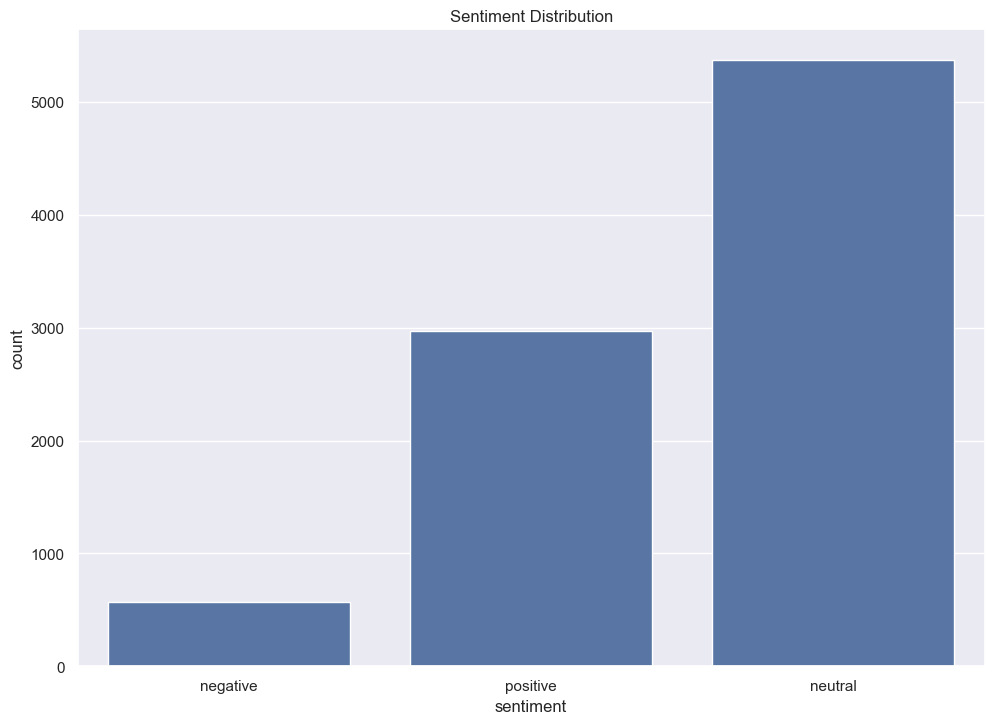

In [35]:
sns.countplot(x='sentiment', data=df)
plt.title("Sentiment Distribution")
plt.show()




              precision    recall  f1-score   support

    negative       0.48      0.67      0.56       106
    positive       0.94      0.87      0.90       602

    accuracy                           0.84       708
   macro avg       0.71      0.77      0.73       708
weighted avg       0.87      0.84      0.85       708



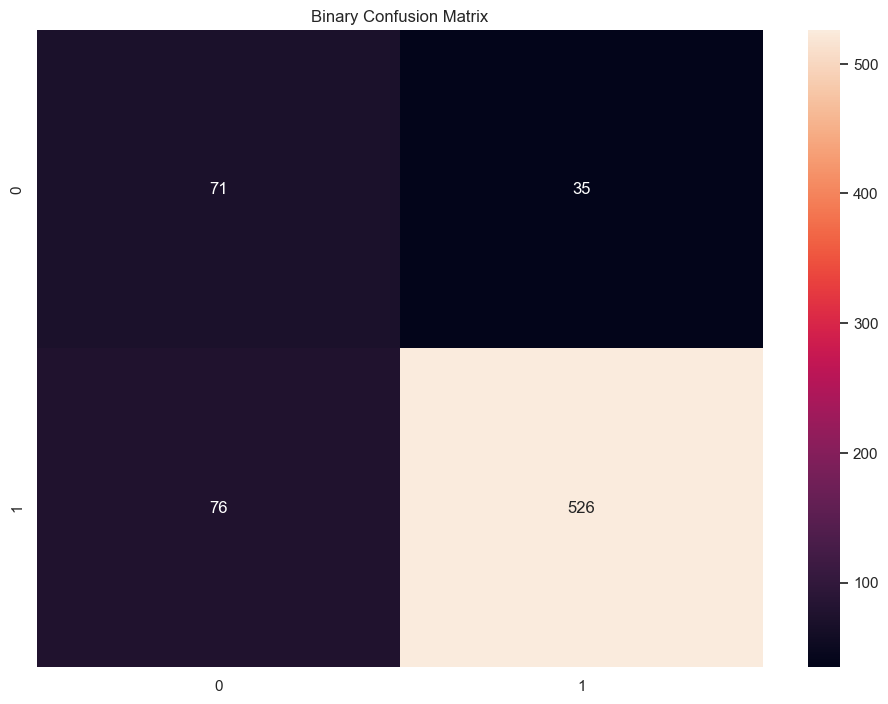

In [36]:
binary_df = df[df['sentiment'].isin(['positive','negative'])]
X_train, X_test, y_train, y_test = train_test_split(binary_df['clean_text'], binary_df['sentiment'], test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

binary_model = LogisticRegression(max_iter=1000, class_weight='balanced')
binary_model.fit(X_train_tfidf, y_train)

y_pred = binary_model.predict(X_test_tfidf)
print(classification_report(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')
plt.title("Binary Confusion Matrix")
plt.show()


In [37]:
binary_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3539 entries, 0 to 9088
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   tweet_text  3539 non-null   object
 1   sentiment   3539 non-null   object
 2   clean_text  3539 non-null   object
dtypes: object(3)
memory usage: 110.6+ KB


              precision    recall  f1-score   support

    negative       0.30      0.53      0.39       117
     neutral       0.79      0.66      0.72      1077
    positive       0.56      0.63      0.59       589

    accuracy                           0.64      1783
   macro avg       0.55      0.61      0.57      1783
weighted avg       0.68      0.64      0.65      1783



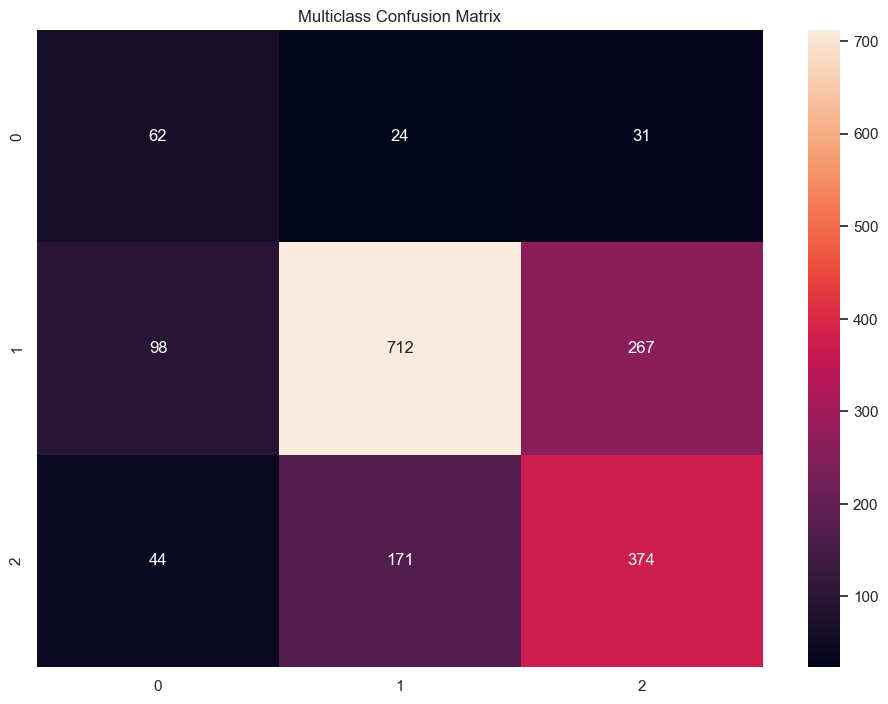

In [38]:
X_train, X_test, y_train, y_test = train_test_split(df['clean_text'], df['sentiment'], test_size=0.2, random_state=42)

multi_model = LogisticRegression(max_iter=1000, class_weight='balanced')
multi_model.fit(vectorizer.fit_transform(X_train), y_train)

y_pred_multi = multi_model.predict(vectorizer.transform(X_test))
print(classification_report(y_test, y_pred_multi))
sns.heatmap(confusion_matrix(y_test, y_pred_multi), annot=True, fmt='d')
plt.title("Multiclass Confusion Matrix")
plt.show()


In [39]:
# SVM
svm_model = LinearSVC(class_weight='balanced')
svm_model.fit(vectorizer.fit_transform(X_train), y_train)
print(classification_report(y_test, svm_model.predict(vectorizer.transform(X_test))))

# Random Forest
rf_model = RandomForestClassifier(n_estimators=200, class_weight='balanced')
rf_model.fit(vectorizer.fit_transform(X_train), y_train)
print(classification_report(y_test, rf_model.predict(vectorizer.transform(X_test))))


              precision    recall  f1-score   support

    negative       0.34      0.38      0.36       117
     neutral       0.74      0.74      0.74      1077
    positive       0.58      0.57      0.57       589

    accuracy                           0.66      1783
   macro avg       0.55      0.56      0.56      1783
weighted avg       0.66      0.66      0.66      1783

              precision    recall  f1-score   support

    negative       0.62      0.21      0.31       117
     neutral       0.69      0.86      0.76      1077
    positive       0.61      0.42      0.50       589

    accuracy                           0.67      1783
   macro avg       0.64      0.49      0.52      1783
weighted avg       0.66      0.67      0.65      1783



In [44]:
svm_model.score(vectorizer.transform(X_test), y_test)

0.6584408300616937

In [45]:
rf_model.score(vectorizer.transform(X_test), y_test)

0.6690970274817722

In [46]:
multi_model.score(vectorizer.transform(X_test), y_test)

0.64385866517106

In [40]:
from imblearn.over_sampling import SMOTE

X_train_tfidf, y_train_balanced = SMOTE(random_state=42).fit_resample(vectorizer.fit_transform(X_train), y_train)

model_balanced = LogisticRegression(max_iter=1000)
model_balanced.fit(X_train_tfidf, y_train_balanced)

y_pred_balanced = model_balanced.predict(vectorizer.transform(X_test))
print(classification_report(y_test, y_pred_balanced))


              precision    recall  f1-score   support

    negative       0.32      0.50      0.39       117
     neutral       0.76      0.68      0.72      1077
    positive       0.55      0.60      0.57       589

    accuracy                           0.64      1783
   macro avg       0.54      0.59      0.56      1783
weighted avg       0.66      0.64      0.65      1783



In [41]:
df['tweet_length'] = df['clean_text'].apply(len)
df['exclamations'] = df['tweet_text'].apply(lambda x: x.count('!'))


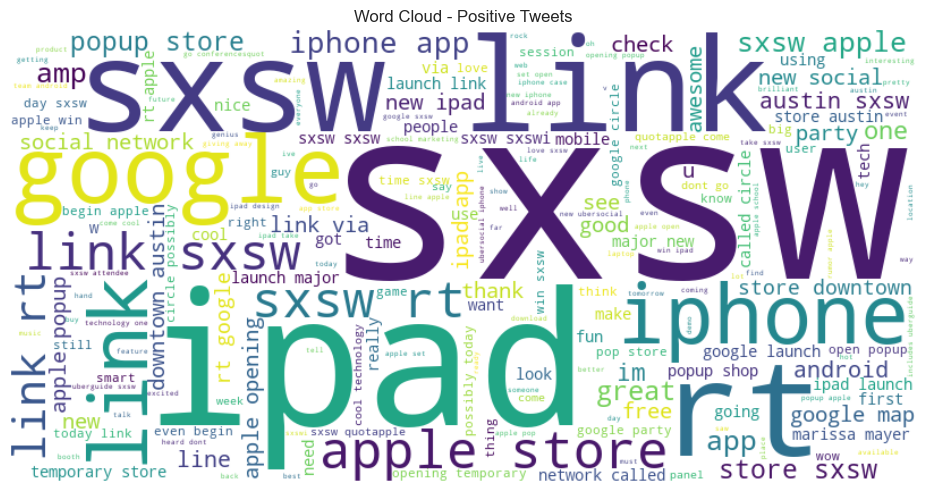

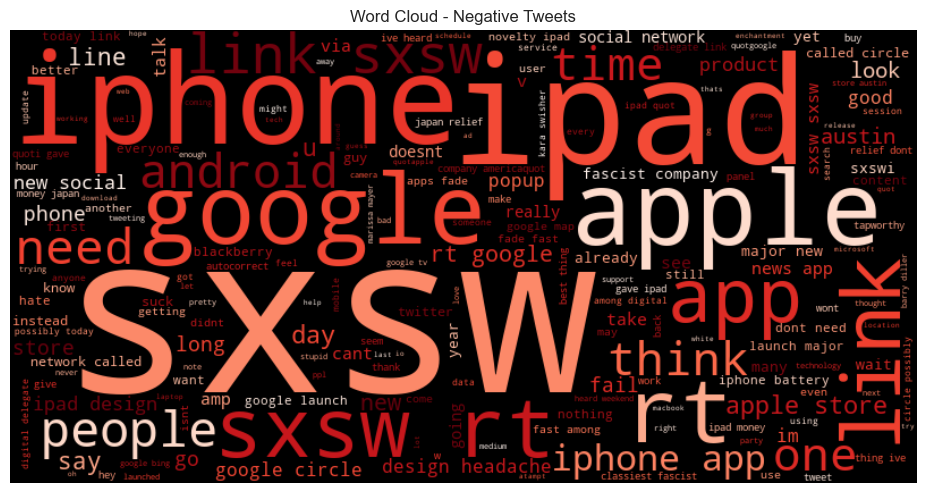

In [42]:
from wordcloud import WordCloud

positive_text = " ".join(df[df['sentiment']=='positive']['clean_text'])
wordcloud_pos = WordCloud(width=800, height=400, background_color='white').generate(positive_text)

plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud - Positive Tweets")
plt.show()

negative_text = " ".join(df[df['sentiment']=='negative']['clean_text'])
wordcloud_neg = WordCloud(width=800, height=400, background_color='black', colormap='Reds').generate(negative_text)

plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud - Negative Tweets")
plt.show()


In [43]:
results = {
    "Logistic Regression": classification_report(y_test, y_pred_multi, output_dict=True),
    "SVM": classification_report(y_test, svm_model.predict(vectorizer.transform(X_test)), output_dict=True),
    "Random Forest": classification_report(y_test, rf_model.predict(vectorizer.transform(X_test)), output_dict=True),
    "Balanced Logistic Regression": classification_report(y_test, y_pred_balanced, output_dict=True),
}

pd.DataFrame({model: res['weighted avg'] for model, res in results.items()}).T


,precision,recall,f1-score,support
Logistic Regression,0.677968,0.643859,0.654844,1783.0
SVM,0.661862,0.658441,0.660026,1783.0
Random Forest,0.657784,0.669097,0.645177,1783.0
Balanced Logistic Regression,0.663780,0.640494,0.648897,1783.0
